# Image Segmentation by Supervised Learning

## import libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

## load data

In [ ]:
directory_data  = './data'
filename_data   = 'assignment_09_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

*************************************************
size of x_train : (600, 128, 128)
size of y_train : (600, 128, 128)
*************************************************
size of x_test : (400, 128, 128)
size of y_test : (400, 128, 128)
*************************************************
number of training image : 600
height of training image : 128
width of training image : 128
*************************************************
number of testing image : 400
height of testing image : 128
width of testing image : 128
*************************************************


## hyper-parameters

In [ ]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 2500
size_minibatch  = 8
learning_rate   = 0.2
weight_decay    = 0.0001

## custom data loader for the PyTorch framework

In [ ]:
class dataset(Dataset):
    
    def __init__(self, image, label, transform=False):
        
        self.image  = image
        self.label  = label 
        self.transform = transform
    
    def __getitem__(self, index):
        
        image   = self.image[index]
        label   = self.label[index]
        
        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        label   = torch.FloatTensor(label).unsqueeze(dim=0)

        # label   = torch.LongTensor(label).unsqueeze(dim=0)

        image   = transforms.Resize(size=[64,64], interpolation=transforms.InterpolationMode('bilinear'))(image)
        label   = transforms.Resize(size=[64,64], interpolation=transforms.InterpolationMode('nearest'))(label)
        



        if self.transform:
            # ==================================================
            # you can apply data augmentation here
            #
            
            r = np.random.randint(1, 5)
            # # Horizontal flip
            # if r == 1:
            #     image = transforms.functional.hflip(image)
            #     label = transforms.functional.hflip(label)
            # # Vertical flip
            # elif r == 2:
            #     image = transforms.functional.vflip(image)
            #     label = transforms.functional.vflip(label)
            # Rotate
            if r == 1:
                r_angle = np.random.randint(0, 360)
                image = transforms.functional.rotate(image, r_angle)
                label = transforms.functional.rotate(label, r_angle)
            
            elif r == 2:
                r_width = np.random.randint(16, 49)
                r_height = np.random.randint(16, 49)
                r_top = np.random.randint(0, 64 - r_height)
                r_left = np.random.randint(0, 64 - r_width)
                image = transforms.functional.resized_crop(image, r_top, r_left, r_height, r_width, (64, 64))
                label = transforms.functional.resized_crop(label, r_top, r_left, r_height, r_width, (64, 64))
            elif r == 3:
                r_width = np.random.randint(32, 49)
                r_height = np.random.randint(32, 49)
                r_top = np.random.randint(0, 64 - r_height)
                r_left = np.random.randint(0, 64 - r_width)
                image = transforms.functional.resized_crop(image, r_top, r_left, r_height, r_width, (64, 64))
                label = transforms.functional.resized_crop(label, r_top, r_left, r_height, r_width, (64, 64))
            elif r == 4:
                ad = np.random.rand(1)[0] + 1
                image = transforms.functional.adjust_brightness(image, ad)
            

            
            #
            # ==================================================
            
        return (image, label)
    
    def __len__(self):
        
        return self.image.shape[0]

## construct datasets and dataloaders for training and testing

In [ ]:
dataset_train_transform = dataset(x_train, y_train, transform=True)
dataset_train           = dataset(x_train, y_train)
dataset_test            = dataset(x_test, y_test)

dataloader_train_transform  = DataLoader(dataset_train_transform, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_train            = DataLoader(dataset_train, batch_size=size_minibatch, shuffle=False, drop_last=True)
dataloader_test             = DataLoader(dataset_test, batch_size=size_minibatch, shuffle=False, drop_last=True)

## shape of the data when using the data loader

In [ ]:
(image_train, label_train)  = dataset_train[0]
(image_test, label_test)    = dataset_test[0]
(image_train_transform, label_train_transform)  = dataset_train_transform[0]
print('*******************************************************************')
print('shape of the image in the training dataset:', image_train.shape)
print('shape of the label in the training dataset:', label_train.shape)
print('*******************************************************************')
print('shape of the image in the testing dataset:', image_test.shape)
print('shape of the label in the testing dataset:', label_test.shape)
print('*******************************************************************')
print('shape of the image in the training transform dataset:', image_train_transform.shape)
print('shape of the label in the training transform dataset:', label_train_transform.shape)
print('*******************************************************************')

*******************************************************************
shape of the image in the training dataset: torch.Size([1, 64, 64])
shape of the label in the training dataset: torch.Size([1, 64, 64])
*******************************************************************
shape of the image in the testing dataset: torch.Size([1, 64, 64])
shape of the label in the testing dataset: torch.Size([1, 64, 64])
*******************************************************************
shape of the image in the training transform dataset: torch.Size([1, 64, 64])
shape of the label in the training transform dataset: torch.Size([1, 64, 64])
*******************************************************************


## class for the neural network 

In [ ]:
class CBR(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CBR, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
        )
    
    def forward(self, x):
        return self.layer(x)


class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # -------------------------------------------------
        # Encoder
        # -------------------------------------------------
        self.e_layer1 = nn.Sequential(
                        CBR(in_channels=1, out_channels=64),
                        CBR(in_channels=64, out_channels=64),
        )
        
        self.e_pool1 = nn.MaxPool2d(kernel_size=2)

        self.e_layer2 = nn.Sequential(
                        CBR(in_channels=64, out_channels=128),
                        CBR(in_channels=128, out_channels=128),
        )

        self.e_pool2 = nn.MaxPool2d(kernel_size=2)

        self.e_layer3 = nn.Sequential(
                        CBR(in_channels=128, out_channels=256),
                        CBR(in_channels=256, out_channels=256),
        )

        self.e_pool3 = nn.MaxPool2d(kernel_size=2)

        self.e_layer4 = nn.Sequential(
                        CBR(in_channels=256, out_channels=512),
                        CBR(in_channels=512, out_channels=512),
        )

        self.e_pool4 = nn.MaxPool2d(kernel_size=2)
        
        # self.e_layer5 = nn.Sequential(
        #                 CBR(in_channels=512, out_channels=1024),
        #                 CBR(in_channels=1024, out_channels=1024),
        # )

        # self.e_pool5 = nn.MaxPool2d(kernel_size=2)

        # -------------------------------------------------
        # Bottleneck
        # -------------------------------------------------

        self.bottleneck = nn.Sequential(
                        CBR(in_channels=512, out_channels=1024),
                        CBR(in_channels=1024, out_channels=512),
        )

        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------

        # self.d_up5 = nn.ConvTranspose2d(in_channels=1024, out_channels=1024, kernel_size=2, stride=2, padding=0, bias=True)

        # self.d_layer5 = nn.Sequential(
        #                 CBR(in_channels=2048, out_channels=1024),
        #                 CBR(in_channels=1024, out_channels=512),
        # )        

        self.d_up4 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0, bias=True)

        self.d_layer4 = nn.Sequential(
                        CBR(in_channels=1024, out_channels=512),
                        CBR(in_channels=512, out_channels=256),
        )

        self.d_up3 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True)

        self.d_layer3 = nn.Sequential(
                        CBR(in_channels=512, out_channels=256),
                        CBR(in_channels=256, out_channels=128),
        )

        self.d_up2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True)

        self.d_layer2 = nn.Sequential(
                        CBR(in_channels=256, out_channels=128),
                        CBR(in_channels=128, out_channels=64),
        )

        self.d_up1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True)

        self.d_layer1 = nn.Sequential(
                        CBR(in_channels=128, out_channels=64),
                        CBR(in_channels=64, out_channels=64),
                        nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True),
                        nn.Sigmoid()
        )

    def forward(self,x):
    
        enc1 = self.e_layer1(x)
        pool1 = self.e_pool1(enc1)
        enc2 = self.e_layer2(pool1)
        pool2 = self.e_pool2(enc2)
        enc3 = self.e_layer3(pool2)
        pool3 = self.e_pool3(enc3)
        enc4 = self.e_layer4(pool3)
        pool4 = self.e_pool4(enc4)
        # enc5 = self.e_layer5(pool4)
        # pool5 = self.e_pool5(enc5)

        bottle = self.bottleneck(pool4)

        # up5 = self.d_up5(bottle)
        # cat5 = torch.cat((up5, enc5), 1)
        # dec5 = self.d_layer5(cat5)
        up4 = self.d_up4(bottle)
        cat4 = torch.cat((up4, enc4), 1)
        dec4 = self.d_layer4(cat4)
        up3 = self.d_up3(dec4)
        cat3 = torch.cat((up3, enc3), 1)
        dec3 = self.d_layer3(cat3)
        up2 = self.d_up2(dec3)
        cat2 = torch.cat((up2, enc2), 1)
        dec2 = self.d_layer2(cat2)
        up1 = self.d_up1(dec2)
        cat1 = torch.cat((up1, enc1), 1)
        out = self.d_layer1(cat1)

        return out


## build network

In [ ]:
model       = Network().to(device)
optimizer   = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [1200, 1800, 2100, 2400], gamma=0.5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00001, 
#                                               step_size_up=5, max_lr=0.01, 
#                                               gamma=0.5, mode='triangular2')

## compute the prediction

In [ ]:
def compute_prediction(model, input):
    # ==================================================
    # fill up the blank
    #

    prediction = model(input)
    
    # 
    # ==================================================
    return prediction

## compute the loss

In [ ]:
def compute_loss(prediction, label):
    # ==================================================
    # fill up the blank
    #
    # print(label.shape)
    mse = nn.MSELoss()
    loss =  mse(prediction, label)
    # print(torch.squeeze(label.long(), 1).to(device))
    # print(prediction[0])
    
    # cee = nn.CrossEntropyLoss()
    # loss = cee(prediction, torch.squeeze(label, 1))
    

    
    # 
    # ==================================================
    loss_value  = loss.item()

    return loss, loss_value

## compute the accuracy

In [ ]:
def compute_accuracy(prediction, label):
    
    prediction  = prediction.squeeze(axis=1)
    label       = label.squeeze(axis=1)

    prediction_binary   = (prediction >= 0.5).cpu().numpy()
    label               = label.bool().cpu().numpy()
    
    region_intersection = prediction_binary & label
    region_union        = prediction_binary | label

    area_intersection   = region_intersection.sum(axis=1).sum(axis=1).astype(float)
    area_union          = region_union.sum(axis=1).sum(axis=1).astype(float)

    eps         = np.finfo(float).eps
    correct     = area_intersection / (area_union + eps)
    accuracy    = correct.mean() * 100.0
    
    return accuracy

## variables for the learning curve

In [ ]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train

In [ ]:
def train(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.train()

    for index_batch, (image, label) in enumerate(dataloader):

        image = image.to(device)
        label = label.to(device)

        # ==================================================
        # fill up the blank 
        #

        prediction          = compute_prediction(model, image)
        loss, loss_value    = compute_loss(prediction, label)
        accuracy            = compute_accuracy(prediction, label)
        
        # 
        # ==================================================

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    scheduler.step()
    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    


## test

In [ ]:
def test(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.eval()

    for index_batch, (image, label) in enumerate(dataloader):

        image = image.to(device)
        label = label.to(device)

        # ==================================================
        # fill up the blank 
        #

        prediction          = compute_prediction(model, image)
        loss, loss_value    = compute_loss(prediction, label)
        accuracy            = compute_accuracy(prediction, label)
        
        # 
        # ==================================================

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)    

## train and test

In [ ]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, accuracy_train) = train(model, dataloader_train_transform)

    loss_mean_train[i]      = loss_train['mean']
    loss_std_train[i]       = loss_train['std']

    accuracy_mean_train[i]  = accuracy_train['mean']
    accuracy_std_train[i]   = accuracy_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, accuracy_test) = test(model, dataloader_test)

    loss_mean_test[i]      = loss_test['mean']
    loss_std_test[i]       = loss_test['std']

    accuracy_mean_test[i]  = accuracy_test['mean']
    accuracy_std_test[i]   = accuracy_test['std']

100%|██████████| 2500/2500 [1:39:48<00:00,  2.40s/it]


---

# functions for visualizing the results 

---

## plot curve

In [ ]:
def plot_data_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [ ]:
def plot_data_tensor_grid(data, index_data, nRow, nCol):
    
    size_col = 1.5
    size_row = 1.5

    fig, axes = plt.subplots(nRow, nCol, constrained_layout=True, figsize=(nCol * size_col, nRow * size_row))

    data = data.detach().cpu().squeeze(axis=1)

    for i in range(nRow):
        for j in range(nCol):

            k       = i * nCol + j
            index   = index_data[k]

            axes[i, j].imshow(data[index], cmap='gray', vmin=0, vmax=1)
            axes[i, j].xaxis.set_visible(False)
            axes[i, j].yaxis.set_visible(False)

    plt.show()

In [ ]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [ ]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [ ]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [ ]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [ ]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [ ]:
def function_result_01():

    print('[plot examples of the training images]')
    print('') 

    nRow = 8
    nCol = 6
    index_data  = np.arange(0, nRow * nCol)
    image_train,_ = dataset_train[index_data]
    image_train = image_train[0]
    
    plot_data_grid(image_train, index_data, nRow, nCol)

In [ ]:
def function_result_02():

    print('[plot examples of the training segmentation labels]')
    print('') 
    
    nRow = 8
    nCol = 6
    index_data  = np.arange(0, nRow * nCol)
    _,label_train = dataset_train[index_data]
    label_train = label_train[0]
    
    plot_data_grid(label_train, index_data, nRow, nCol)

In [ ]:
def function_result_03():

    print('[plot examples of the training segmentation results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data          = np.arange(0, nRow * nCol)
    image_train,_       = dataset_train[index_data] 
    image_train         = image_train[0].unsqueeze(dim=1).to(device)
    prediction_train    = compute_prediction(model, image_train)
    
    plot_data_tensor_grid(prediction_train, index_data, nRow, nCol)

In [ ]:
def function_result_04():

    print('[plot examples of the testing images]')
    print('') 
    
    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    image_test,_    = dataset_test[index_data]
    image_test      = image_test[0]
    
    plot_data_grid(image_test, index_data, nRow, nCol)

In [ ]:
def function_result_05():

    print('[plot examples of the testing segmentation labels]')
    print('') 

    nRow = 8
    nCol = 6
    index_data = np.arange(0, nRow * nCol)
    _,label_test = dataset_test[index_data]
    label_test = label_test[0]
    
    plot_data_grid(label_test, index_data, nRow, nCol)

In [ ]:
def function_result_06():

    print('[plot examples of the testing segmentation results]')
    print('') 

    nRow = 8
    nCol = 6
    index_data      = np.arange(0, nRow * nCol)
    image_test,_    = dataset_test[index_data]
    image_test      = image_test[0].unsqueeze(dim=1).to(device)
    prediction_test = compute_prediction(model, image_test)
    
    plot_data_tensor_grid(prediction_test, index_data, nRow, nCol)

In [ ]:
def function_result_07():

    print('[plot the training loss]')
    print('') 

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [ ]:
def function_result_08():

    print('[plot the training accuracy]')
    print('') 
    
    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [ ]:
def function_result_09():
    
    print('[plot the testing loss]')
    print('') 
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [ ]:
def function_result_10():
    
    print('[plot the testing accuracy]') 
    print('') 
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [ ]:
def function_result_11():
    
    print('[print the training loss at the last 10 epochs]')
    print('') 

    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [ ]:
def function_result_12():
    
    print('[print the training accuracy at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(accuracy_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [ ]:
def function_result_13():
    
    print('[print the testing loss at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [ ]:
def function_result_14():
    
    print('[print the testing accuracy at the last 10 epochs]')
    print('') 
    
    data_last = get_data_last(accuracy_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [ ]:
def function_result_15():
    
    print('[print the best training accuracy within the last 10 epochs]')
    print('') 

    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [ ]:
def function_result_16():
    
    print('[print the best testing accuracy within the last 10 epochs]')
    print('') 
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---


################################################################################
#
# RESULT # 01
#
################################################################################

[plot examples of the training images]



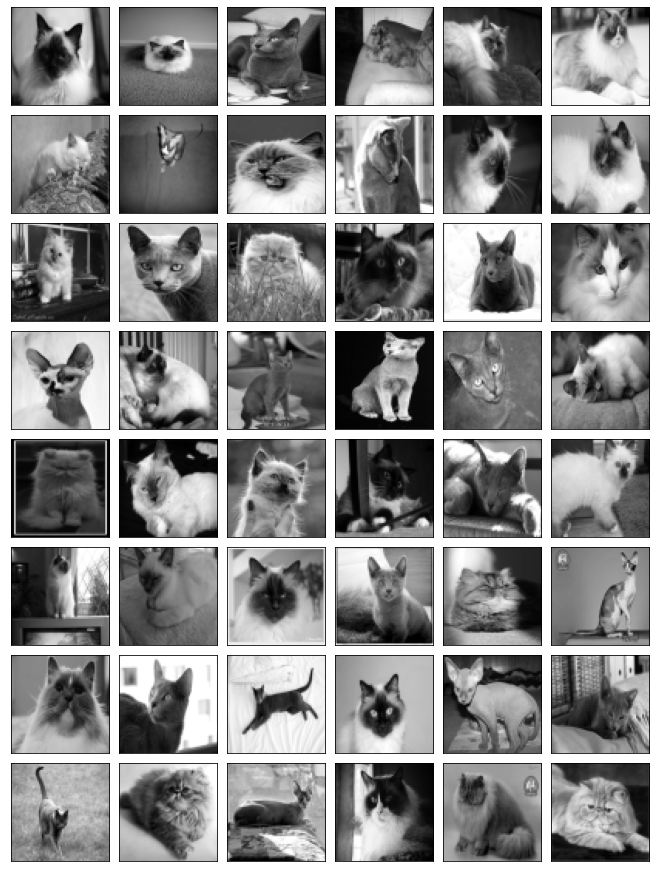


################################################################################
#
# RESULT # 02
#
################################################################################

[plot examples of the training segmentation labels]



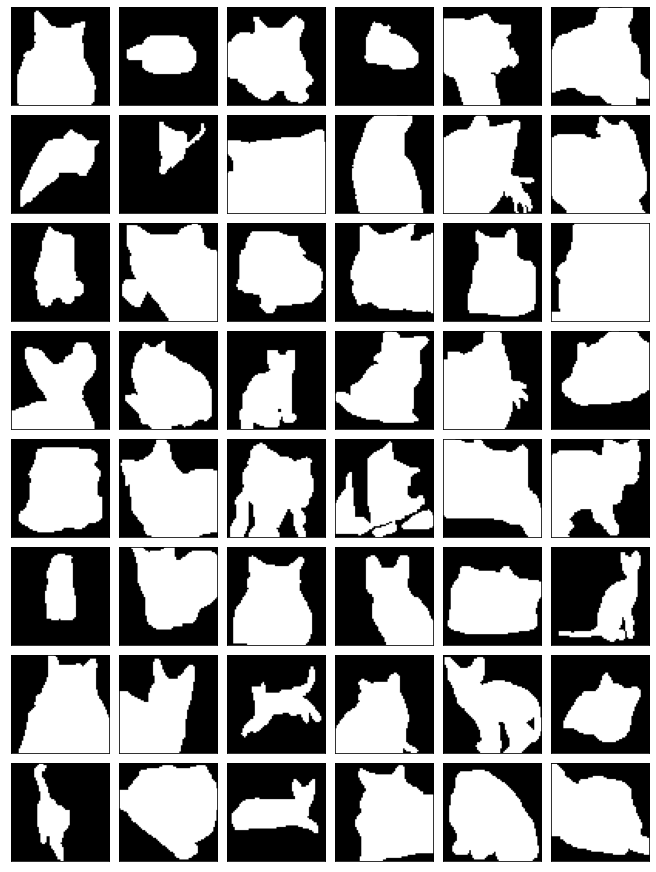


################################################################################
#
# RESULT # 03
#
################################################################################

[plot examples of the training segmentation results]



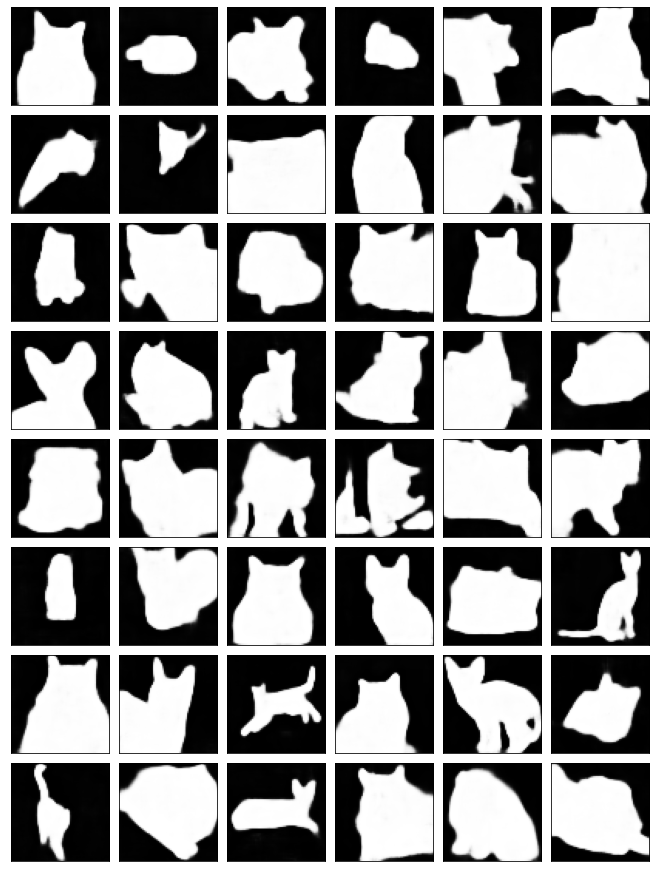


################################################################################
#
# RESULT # 04
#
################################################################################

[plot examples of the testing images]



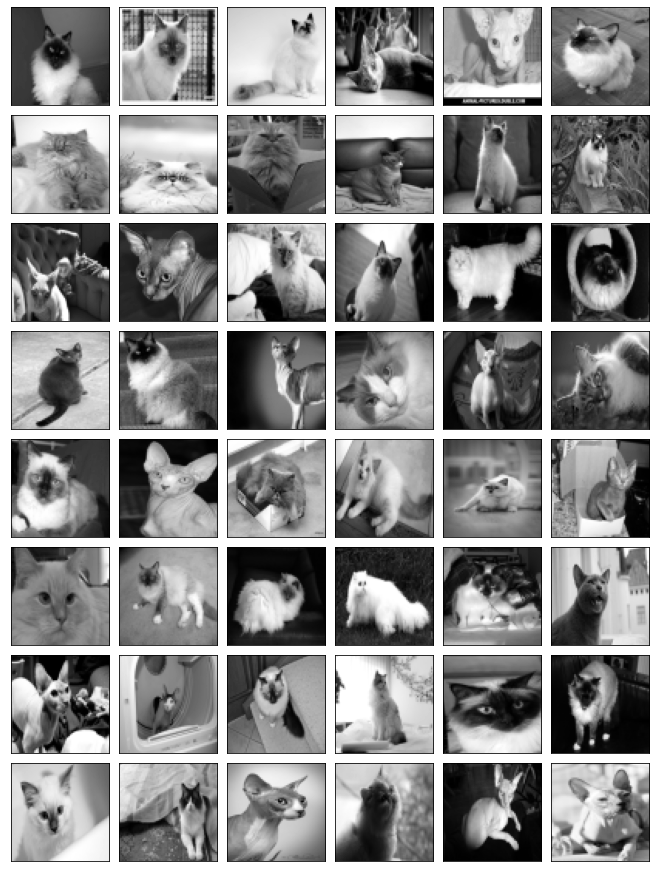


################################################################################
#
# RESULT # 05
#
################################################################################

[plot examples of the testing segmentation labels]



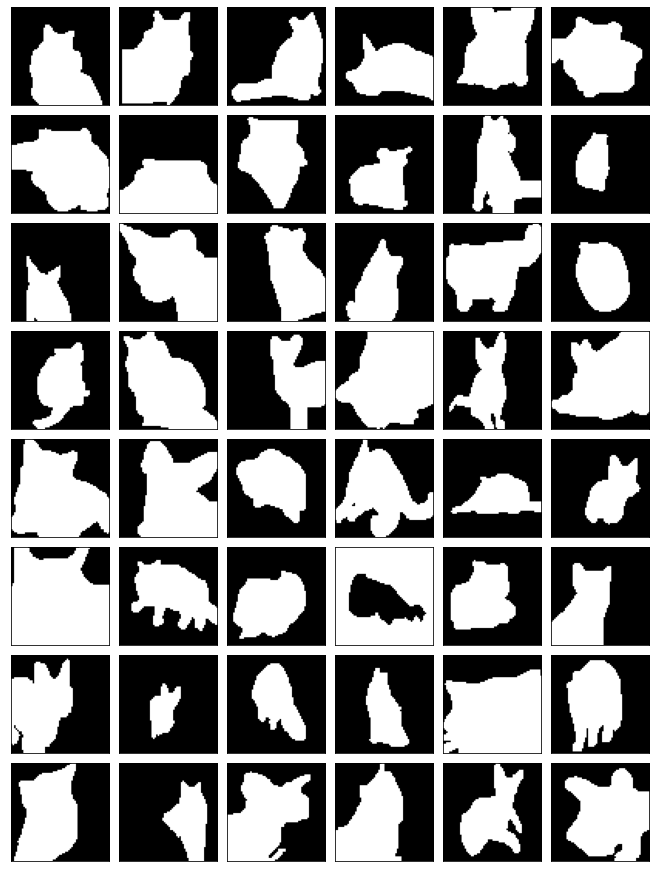


################################################################################
#
# RESULT # 06
#
################################################################################

[plot examples of the testing segmentation results]



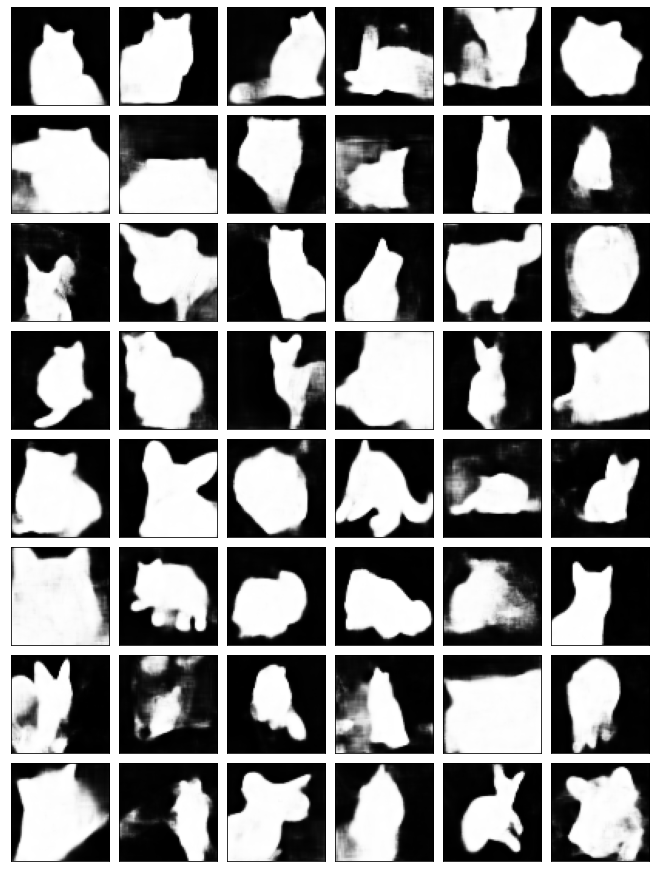


################################################################################
#
# RESULT # 07
#
################################################################################

[plot the training loss]



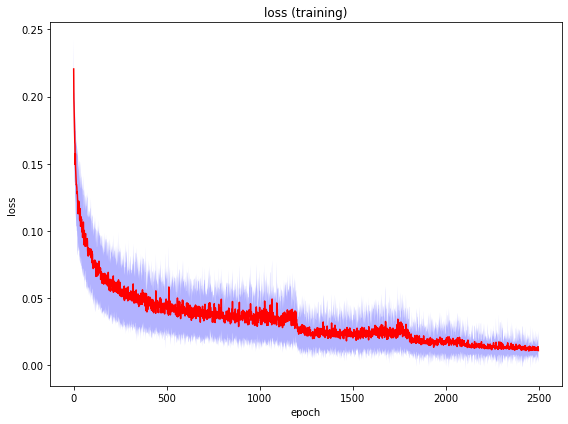


################################################################################
#
# RESULT # 08
#
################################################################################

[plot the training accuracy]



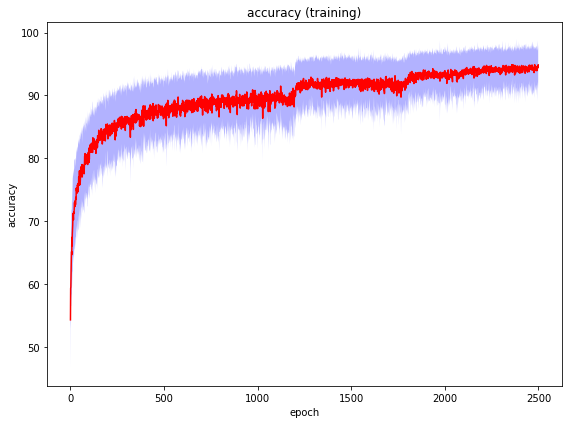


################################################################################
#
# RESULT # 09
#
################################################################################

[plot the testing loss]



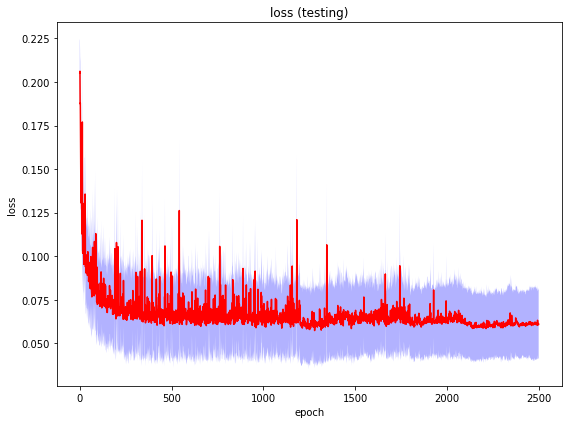


################################################################################
#
# RESULT # 10
#
################################################################################

[plot the testing accuracy]



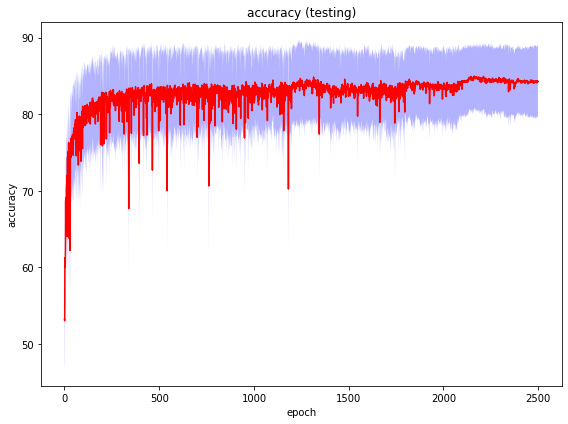


################################################################################
#
# RESULT # 11
#
################################################################################

[print the training loss at the last 10 epochs]

index =  0, value = 0.0111643262
index =  1, value = 0.0119112526
index =  2, value = 0.0122133023
index =  3, value = 0.0123132573
index =  4, value = 0.0114551074
index =  5, value = 0.0134119421
index =  6, value = 0.0114333123
index =  7, value = 0.0124446541
index =  8, value = 0.0137064512
index =  9, value = 0.0108910667

################################################################################
#
# RESULT # 12
#
################################################################################

[print the training accuracy at the last 10 epochs]

index =  0, value = 94.4285288188
index =  1, value = 94.4246421970
index =  2, value = 94.5162743531
index =  3, value = 93.9532726251
index =  4, value = 94.3847604291
index =  5, value = 94.4338679844


In [ ]:
number_result = 16

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)